In [1]:
import gc
import time
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
import click
from logzero import logger

In [2]:
ls -lah ../data/*.feather

-rw-r--r-- 1 ubuntu ubuntu  14K May  5 12:59 ../data/agg_by_app.feather
-rw-r--r-- 1 ubuntu ubuntu 4.3K May  5 04:22 ../data/agg_by_channel.feather
-rw-r--r-- 1 ubuntu ubuntu 113K May  5 18:42 ../data/app_pca.feather
-rw-r--r-- 1 ubuntu ubuntu  35K May  5 05:47 ../data/channel_pca.feather
-rw-r--r-- 1 ubuntu ubuntu 4.8G Apr 30 14:27 ../data/click_data.feather
-rw-r--r-- 1 ubuntu ubuntu 941K May  5 18:32 ../data/count_app_coincidence_per_user.feather
-rw-r--r-- 1 ubuntu ubuntu  93K May  5 04:53 ../data/count_channel_coincidence_per_user.feather
-rw-r--r-- 1 ubuntu ubuntu 1.1M May  5 13:04 ../data/count_user_by_app_channel.feather
-rw-r--r-- 1 ubuntu ubuntu 1.1M May  5 04:27 ../data/count_user_by_channel_app.feather
-rw-r--r-- 1 ubuntu ubuntu  18G May  4 07:40 ../data/merge.feather
-rw-r--r-- 1 ubuntu ubuntu  27K May  5 13:03 ../data/uqcount_by_app.feather
-rw-r--r-- 1 ubuntu ubuntu 8.4K May  5 04:26 ../data/uqcount_by_channel.feather


In [3]:
%%time
click_data = pd.read_feather("../data/merge.feather", nthreads=64)

CPU times: user 10.5 s, sys: 7.89 s, total: 18.4 s
Wall time: 1.57 s


In [4]:
%%time
channel_pca = pd.read_feather("../data/channel_pca.feather", nthreads=64).astype('float32')

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.44 ms


In [5]:
%%time
app_pca = pd.read_feather("../data/app_pca.feather", nthreads=64).astype('float32')

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 3.79 ms


### merge

In [6]:
%%time
click_data = pd.merge(click_data, channel_pca, on = 'channel', how='left')

CPU times: user 1min 37s, sys: 40.5 s, total: 2min 18s
Wall time: 2min 18s


In [7]:
%%time
click_data = pd.merge(click_data, app_pca, on = 'app', how='left')

CPU times: user 1min 32s, sys: 49.3 s, total: 2min 22s
Wall time: 2min 22s


In [8]:
click_data.head()

,app,channel,click_id,device,ip,is_attributed,os,click_time,is_test,dow,...,app_pca_11,app_pca_12,app_pca_13,app_pca_14,app_pca_15,app_pca_16,app_pca_17,app_pca_18,app_pca_19,app_pca_20
0,23,153,99999999,1,76508,0,35,2017-11-07 03:00:00,False,1,...,-148829.703125,-157781.625000,-317459.781250,92268.734375,76491.906250,10405.283203,64472.675781,157667.937500,-9768.283203,-880.104919
1,18,134,99999999,1,76508,0,35,2017-11-07 03:02:24,False,1,...,3706.544922,-90806.328125,28995.509766,4593.960938,19202.978516,3635.911865,13404.356445,14932.370117,-3071.090332,831.772217
2,15,315,99999999,1,76508,0,35,2017-11-07 03:02:29,False,1,...,14029.517578,14226.140625,44448.125000,-18506.320312,-9581.847656,5288.175781,12776.972656,-17392.980469,11749.690430,-2048.725830
3,11,469,99999999,1,76508,0,35,2017-11-07 03:02:32,False,1,...,114676.500000,251829.406250,367176.250000,-202248.375000,580255.125000,-57356.992188,-80007.828125,98644.867188,34344.328125,-11199.667969
4,3,379,99999999,1,76508,0,35,2017-11-07 03:02:36,False,1,...,3161.990234,-1368.264893,1818.902100,-9889.253906,5544.962402,-3005.579590,-551.871643,-652.252808,2119.884766,1191.302612


In [9]:
click_data.shape

(145713707, 77)

In [10]:
click_data.dtypes

app                                                object
channel                                            object
click_id                                           uint32
device                                             uint16
ip                                                 uint32
is_attributed                                       uint8
os                                                 uint16
click_time                                 datetime64[ns]
is_test                                              bool
dow                                                 uint8
hour                                                uint8
minute                                              uint8
min5                                                uint8
second                                              uint8
sin_time                                          float64
cos_time                                          float64
ip_os_device                                       uint64
ip_os_device_d

In [11]:
droplist = ['minute',
            'min5',
            'ip_os_device',
            'ip_os_device_dow_hour',
            'ip_os_device_dow_hour_min5',
            'channel',
            'app',
            'rank_by_ip_os_device_dow_hour',
            'rank_by_ip_os_device_dow_hour_min5',
            'click_id',
            'click_time',
            'click_time_prev',
            'click_time_next'
           ]

In [12]:
%%time
logger.info("Splitting data...")
click_data.drop(columns=droplist, inplace=True)
train = click_data[click_data["dow"] < 3]
valid = click_data[click_data["dow"] == 3]

del click_data
gc.collect()

[I 180505 19:07:21 <timed exec>:1] Splitting data...


CPU times: user 41.6 s, sys: 31.7 s, total: 1min 13s
Wall time: 1min 13s


In [13]:
%%time
y_train = train["is_attributed"].astype("int")
train.drop(columns=["is_attributed"], inplace=True)
y_valid = valid["is_attributed"].astype("int")
valid.drop(columns=["is_attributed"], inplace=True)
gc.collect()

CPU times: user 7.64 s, sys: 7.07 s, total: 14.7 s
Wall time: 14.7 s


In [14]:
%%time
logger.info("Generating matrix...")
dtrain = xgb.DMatrix(train, y_train, nthread=40)
del train, y_train
gc.collect()

dvalid = xgb.DMatrix(valid, y_valid, nthread=40)
del valid, y_valid
gc.collect()

[I 180505 19:08:49 <timed exec>:1] Generating matrix...


CPU times: user 9min 28s, sys: 6min 25s, total: 15min 53s
Wall time: 13min 10s


In [15]:
%%time
n_thread = 64
logger.info("Validating...")
params = {'eta': 0.2,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_depth': 6,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          'colsample_bylevel': 0.7,
          'min_child_weight': 0,
          'alpha': 4,
          'objective': 'binary:logistic',
          'scale_pos_weight': 99,
          'eval_metric': 'auc',
          'nthread': n_thread,
          'random_state': 99,
          'silent': True}
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
model = xgb.train(params,
                  dtrain,
                  500,
                  watchlist,
                  maximize=True,
                  early_stopping_rounds=50,
                  verbose_eval=5)

[I 180505 19:21:59 <timed exec>:2] Validating...


[0]	train-auc:0.962645	valid-auc:0.95018
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[5]	train-auc:0.968466	valid-auc:0.957587
[10]	train-auc:0.970792	valid-auc:0.960989
[15]	train-auc:0.972786	valid-auc:0.963404
[20]	train-auc:0.975191	valid-auc:0.966018
[25]	train-auc:0.976516	valid-auc:0.967851
[30]	train-auc:0.977384	valid-auc:0.968904
[35]	train-auc:0.978107	valid-auc:0.969506
[40]	train-auc:0.978604	valid-auc:0.969926
[45]	train-auc:0.979027	valid-auc:0.970266
[50]	train-auc:0.979376	valid-auc:0.97052
[55]	train-auc:0.979679	valid-auc:0.970702
[60]	train-auc:0.980035	valid-auc:0.971033
[65]	train-auc:0.980311	valid-auc:0.97124
[70]	train-auc:0.980576	valid-auc:0.971359
[75]	train-auc:0.980846	valid-auc:0.971509
[80]	train-auc:0.981077	valid-auc:0.971639
[85]	train-auc:0.981336	valid-auc:0.971782
[90]	train-auc:0.981516	valid-auc:0.971799
[95]	train-auc:0.981709	valid-auc:0.971867
[1

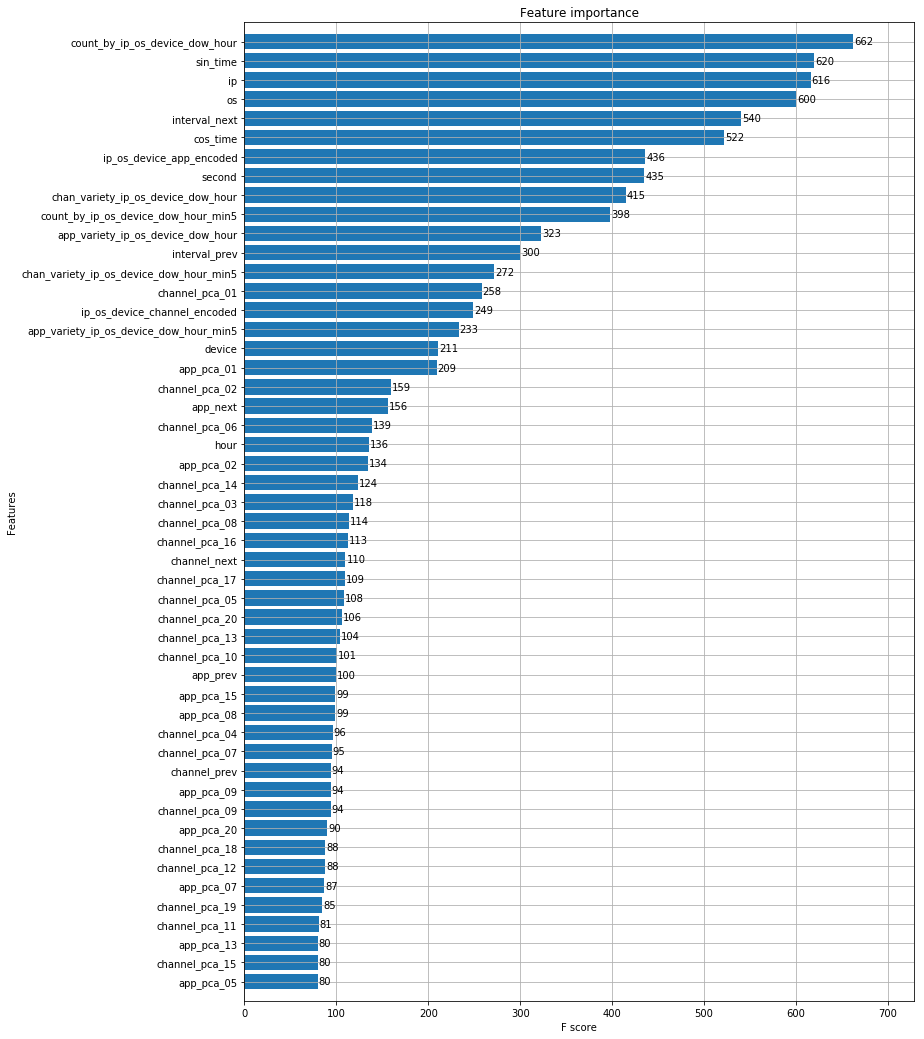

In [16]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

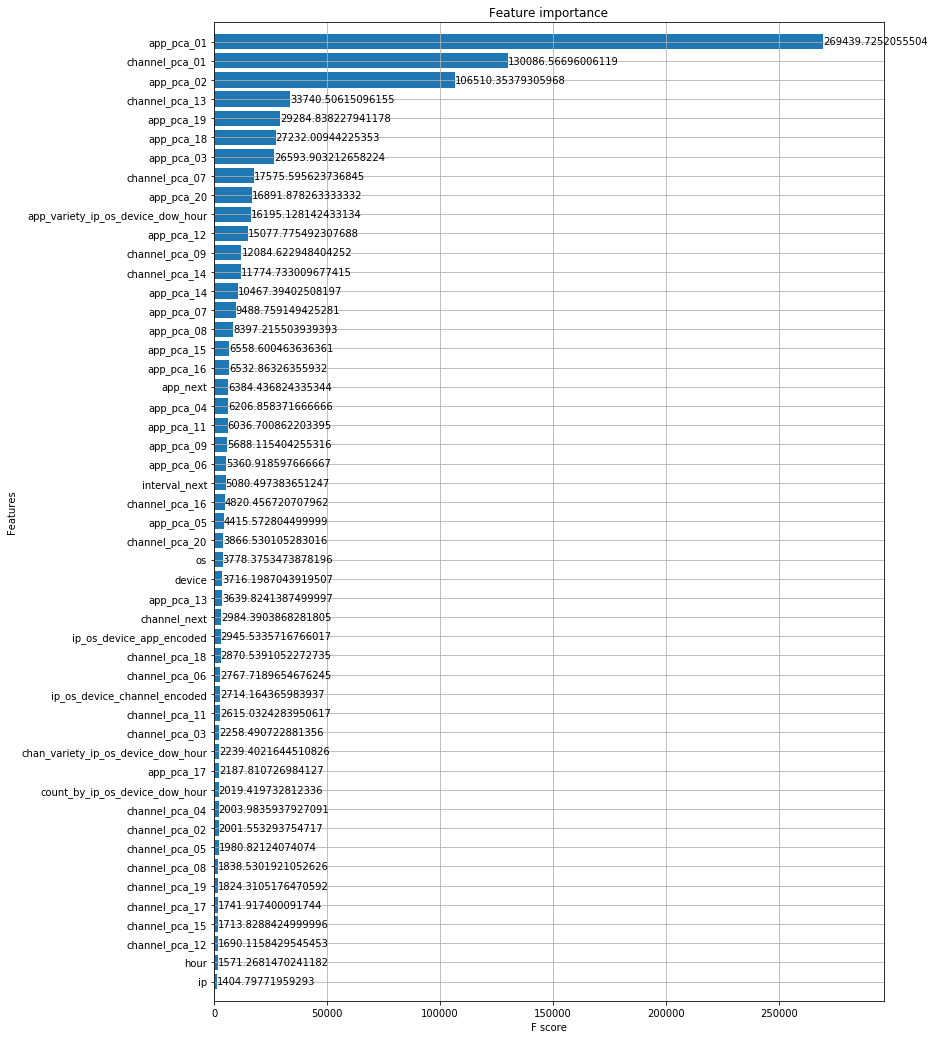

In [17]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax, importance_type='gain')
plt.show()

### predict

In [18]:
%%time
click_data = pd.read_feather("../data/merge.feather", nthreads=64)

CPU times: user 17.8 s, sys: 7.88 s, total: 25.7 s
Wall time: 2min 3s


In [19]:
click_data = click_data[click_data.is_test == True]
click_data = click_data.sort_values('click_id').reset_index()

### merge

In [20]:
%%time
click_data = pd.merge(click_data, channel_pca, on = 'channel', how='left')

CPU times: user 13.5 s, sys: 5.36 s, total: 18.8 s
Wall time: 18.8 s


In [21]:
%%time
click_data = pd.merge(click_data, app_pca, on = 'app', how='left')

CPU times: user 12.4 s, sys: 5.81 s, total: 18.2 s
Wall time: 18.2 s


In [22]:
test = click_data
del click_data
gc.collect()

10174

In [23]:
droplist = ['index', 
            'is_attributed',
            'click_id',
            'minute',
            'min5',
            'ip_os_device',
            'ip_os_device_dow_hour',
            'ip_os_device_dow_hour_min5',
            'channel',
            'app',
            'rank_by_ip_os_device_dow_hour',
            'rank_by_ip_os_device_dow_hour_min5',
            'click_id',
            'click_time',
            'click_time_prev',
            'click_time_next'
           ]

In [24]:
sub = pd.DataFrame()
sub["click_id"] = test["click_id"].astype("int")
test.drop(columns=droplist, inplace=True)
print(sub.shape, test.shape)

(18790469, 1) (18790469, 63)


In [25]:
logger.info("Generating matrix...")
dtest = xgb.DMatrix(test)
del test
gc.collect()

[I 180505 19:58:33 <ipython-input-25-79999e7ff128>:1] Generating matrix...


28

In [26]:
logger.info("Predicting...")
sub['is_attributed'] = model.predict(dtest)
sub.to_csv('xgb_sub.csv', index=False)

[I 180505 20:00:09 <ipython-input-26-f14f7549c823>:1] Predicting...


In [27]:
sub.head()

,click_id,is_attributed
0,0,0.075166
1,1,0.035958
2,2,0.003888
3,3,0.013884
4,4,0.014998
